In [1]:
# 1. Import the following libraries: 
# pip install pandas numpy matplotlib statsmodels scikit-learn

# pandas (for data manipulation)
import pandas as pd
    
# numpy (for numerical operations)
import numpy as np
    
# matplotlib (for data visualization)
import matplotlib.pyplot as plt 
    
# statsmodels (to use ARIMA)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scikit-learn (for error metrics)
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Importing stock data using AlphaVantage API

# !pip install alpha_vantage

from alpha_vantage.timeseries import TimeSeries

#Free API key
key = 'UO4WWNLT3XIKJ6EI'

# Create TimeSeries object
ts = TimeSeries(key, output_format='pandas') #requires input of key and output format (default is json)

# Sample API Call for Tesla
#objects come with a data and a meta component (will likely only need data component), require a stock symbol + interval + output size
predata, meta = ts.get_daily('TSLA', outputsize='full')
data = predata[:1000]


In [3]:
print(data)
print(len(data))

            1. open  2. high    3. low  4. close    5. volume
date                                                         
2024-01-19   209.99   213.19  207.5600    212.19  102260343.0
2024-01-18   216.88   217.45  208.7400    211.88  108595431.0
2024-01-17   214.86   215.67  212.0100    215.55  103164400.0
2024-01-16   215.10   223.49  212.1800    219.91  115355046.0
2024-01-12   220.08   225.34  217.1501    218.89  123043812.0
...             ...      ...       ...       ...          ...
2020-02-05   823.26   845.98  704.1100    734.70   48423837.0
2020-02-04   882.96   968.99  833.8800    887.06   60938758.0
2020-02-03   673.69   786.14  673.5200    780.00   47233495.0
2020-01-31   640.00   653.00  632.5200    650.57   15719266.0
2020-01-30   632.42   650.88  618.0000    640.81   29005676.0

[1000 rows x 5 columns]
1000


In [4]:
# 3. Modify the dataset

# Keep relevant columns - closing price and date
closing_data = data['4. close']
print(closing_data)

date
2024-01-19    212.19
2024-01-18    211.88
2024-01-17    215.55
2024-01-16    219.91
2024-01-12    218.89
               ...  
2020-02-05    734.70
2020-02-04    887.06
2020-02-03    780.00
2020-01-31    650.57
2020-01-30    640.81
Name: 4. close, Length: 1000, dtype: float64


In [5]:
# 4. Separate the data into training and testing datasets

# Create a DataFrame using the closing price data
df = pd.DataFrame(closing_data)
print(df)

# Split data into 70-30 training-testing data sets
# Sort df by ascending order (most recent date comes last)
df.sort_index(ascending=True, inplace=True)
print(df)


# # Testing daily dataset instead of by minute
# hourly_data = df.resample('D').mean()
# df2 = pd.DataFrame(hourly_data)



# train_size represents the first 90% of all rows; use this index to slice the data
train_size = int(len(df) * 0.90)

# Training data will include all rows starting from the first row up to the row indicated by 'train_size'
train_data = df.iloc[:train_size]
# The rest 10% will be included in testing data
test_data = df.iloc[train_size:]

print("Training data: ", train_data)
print("Testing data: ", test_data)

            4. close
date                
2024-01-19    212.19
2024-01-18    211.88
2024-01-17    215.55
2024-01-16    219.91
2024-01-12    218.89
...              ...
2020-02-05    734.70
2020-02-04    887.06
2020-02-03    780.00
2020-01-31    650.57
2020-01-30    640.81

[1000 rows x 1 columns]
            4. close
date                
2020-01-30    640.81
2020-01-31    650.57
2020-02-03    780.00
2020-02-04    887.06
2020-02-05    734.70
...              ...
2024-01-12    218.89
2024-01-16    219.91
2024-01-17    215.55
2024-01-18    211.88
2024-01-19    212.19

[1000 rows x 1 columns]
Training data:              4. close
date                
2020-01-30    640.81
2020-01-31    650.57
2020-02-03    780.00
2020-02-04    887.06
2020-02-05    734.70
...              ...
2023-08-21    231.28
2023-08-22    233.19
2023-08-23    236.86
2023-08-24    230.04
2023-08-25    238.59

[900 rows x 1 columns]
Testing data:              4. close
date                
2023-08-28    238.82
2023-08-29   

<AxesSubplot:xlabel='date'>

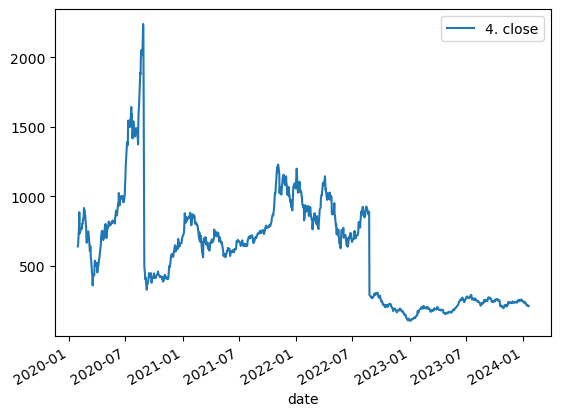

In [6]:
# 5.1 Visualize the data

# Plot the data for visualization
df.plot()

In [7]:
# 5.2 Conduct the ADF test and determine the value for d 

# Conduct the ADF test, which determines if the data is stationary or not
result = adfuller(df)

# Keeps track of the number of times differencing was needed 
d = 0

# If the data is not stationary, differencing is needed to convert it into stationary data
# The p-value has to be less than 0.05 for the dataset to be considered stationary 
while True:
    print('p-value: ', result[1])
    if result[1] < 0.05:
        break
    else:
        result = adfuller(df.diff().dropna())
        d += 1

print('\nd value: ', d)

p-value:  0.06891550565971621
p-value:  0.0

d value:  1


In [8]:
# 6. Optimize the parameters (p, d, q) and create the ARIMA model

    # Determine (p,d,q) based on the data's characteristics
    # ACF plot is used to determine p (autoregressive AR)
    # PACF plot is used to determine q (moving average MA)
    
    # Create the ARIMA model object and fit it to the data
    
    # Examples of useful python code:
    # p, d, q = 1, 1, 1
    # model = ARIMA(data, order(p,d,q))
    # model_fit = model.fit()

            4. close
date                
2020-01-30    640.81
2020-01-31    650.57
2020-02-03    780.00
2020-02-04    887.06
2020-02-05    734.70
...              ...
2024-01-12    218.89
2024-01-16    219.91
2024-01-17    215.55
2024-01-18    211.88
2024-01-19    212.19

[1000 rows x 1 columns]
1000


<Figure size 1500x600 with 0 Axes>

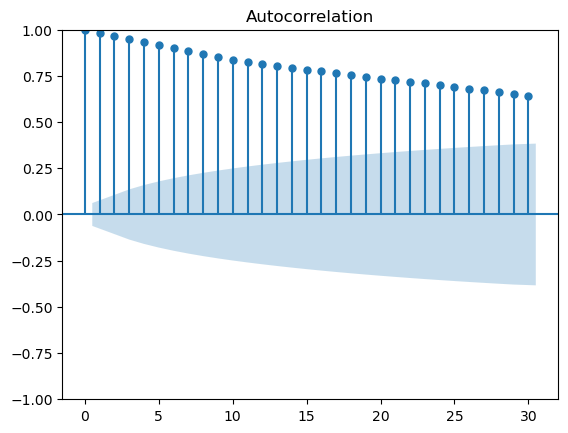

/Users/monasabeti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


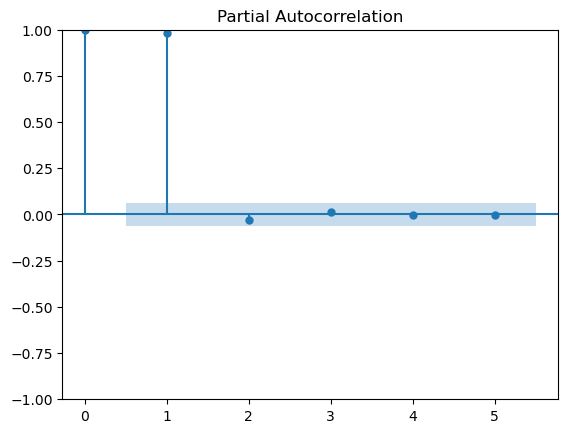

In [9]:
# # Preprocess the data to show daily instead of by minute
# hourly_data = df.resample('D').mean()
# df = pd.DataFrame(hourly_data)


print(df.dropna())
print(len(df.dropna()))


# ACF plot to determine q value (visu)
plt.figure(figsize=(15, 6))
plot_acf(df.dropna())
plt.show()

# PACF plot to determine p value 
plot_pacf(df.dropna(), lags=5)
plt.show()



In [10]:
# 6.1 Determine the best p and q values
# The best p,q,d values will produce the lowest aic value 

import warnings
warnings.filterwarnings("ignore")

# Defines ranges for p and q
p = q = range(0, 4)

# List to store all pdq combinations
pdq = []
# Appends each combination of p,d,q to the list
for p_value in p:
    for q_value in q:
        pdq.append((p_value, d, q_value))

# Initialize best aic to start at infinity
best_aic = float('inf')  
# Initialize best pqd combination 
best_pdq = None

# Test each combination 
for combination in pdq:
    # Fit the arima model 
    model = ARIMA(df, order=(combination))
    model_fit = model.fit()
    
    # If the aic value is lower than the current best aic, it will be replaced
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_pdq = combination

# Extract the p and q values
p = best_pdq[0]
q = best_pdq[2]

print('p value: ', p)
print('q value: ', q)

p value:  3
q value:  3


In [11]:
# 6.2 Create the ARIMA model with the p, d, q values determined
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                 1000
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5583.612
Date:                Sun, 21 Jan 2024   AIC                          11181.223
Time:                        21:07:13   BIC                          11215.570
Sample:                             0   HQIC                         11194.278
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7417      0.461     -3.782      0.000      -2.644      -0.839
ar.L2         -1.7193      0.420     -4.092      0.000      -2.543      -0.896
ar.L3         -0.8144      0.451     -1.805      0.0

In [12]:
# 6.3 Train the ARIMA model with the training data and the p, d, q values determined
model = ARIMA(train_data['4. close'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                  900
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5071.945
Date:                Sun, 21 Jan 2024   AIC                          10157.890
Time:                        21:07:15   BIC                          10191.499
Sample:                             0   HQIC                         10170.730
                                - 900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7736      0.455     -3.899      0.000      -2.665      -0.882
ar.L2         -1.7507      0.418     -4.184      0.000      -2.571      -0.931
ar.L3         -0.8496      0.447     -1.900      0.0

In [13]:
# 7. Make out-of-sample predictions (forecasting)

# fit the model to the training data
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()

# make future predictions for the next week
forecast_steps = 7
print("steps: ", forecast_steps)
# use steps parameter for # of future steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)
print("Predicted value:\n", forecast)

print("\nActual value:\n", test_data.dropna())

steps:  7
Predicted value:
 900    240.965259
901    240.183487
902    239.019084
903    240.434809
904    240.626682
905    238.797145
906    240.503217
Name: predicted_mean, dtype: float64

Actual value:
             4. close
date                
2023-08-28    238.82
2023-08-29    257.18
2023-08-30    256.90
2023-08-31    258.08
2023-09-01    245.01
...              ...
2024-01-12    218.89
2024-01-16    219.91
2024-01-17    215.55
2024-01-18    211.88
2024-01-19    212.19

[100 rows x 1 columns]


In [18]:
# 8. Make a prediction for the closing price of the next day

# Fit the model to all the data
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()

# Make prediction for the next day
forecast = model_fit.forecast(steps=1)
print("Predicted value for tomorrow: ", forecast.iloc[0])

Predicted value for tomorrow:  210.03662135419918
